### Meta-connectivity analysis

In [1]:
# Path to the toolbox
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os 

# GDa functions
import GDa.stats.bursting                as     bst
from   GDa.session                       import session
from   GDa.temporal_network              import temporal_network

import matplotlib.pyplot                 as     plt
import matplotlib
import GDa.graphics.plot                 as     plot

from   mne.viz                           import circular_layout, \
                                                plot_connectivity_circle

import numpy                             as     np
import pandas                            as     pd
import xarray                            as     xr
import brainconn                         as     bc

from   tqdm                              import tqdm
from   sklearn.manifold                  import TSNE
from   scipy                             import stats

In [2]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    return np.array(x_s), np.array(x_t)

#### Plotting and file saving configurations

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [4]:
# Create directory to save figures
if not os.path.exists("img/n5.0.2"):
    os.makedirs("img/n5.0.2")

In [5]:
# Bands names
band_names  = [r'band 1', r'band 2', r'band 3', r'band 4', r'band 5']
stages      = ['baseline', 'cue', 'delay', 'match']
_stats      = [r"$\mu$","std$_{\mu}$",r"$\mu_{tot}$","CV"]

In [6]:
### Methods to read coherence files
def get_coh_file(ks=None, surr=False, mode="morlet"):
    if not surr:
        _COH_FILE = f"coh_k_{ks}_{mode}.nc"
    else:
        _COH_FILE = f"coh_k_{ks}_{mode}_surr.nc"
    return _COH_FILE

In [1]:
###################################################################################
# Instantiate network to get parameters
###################################################################################
net =  temporal_network(coh_file=get_coh_file(ks=0.3, mode="multitaper"), monkey="lucy", 
                        session=1, date='141017', trial_type=[1],
                        behavioral_response=[1], wt=(20,20),
                        verbose=True, q=None)

NameError: name 'temporal_network' is not defined

### Computing MC

In [8]:
import numba as nb

In [9]:
def cross_correlation(data):
    cc = np.corrcoef(data)
    np.fill_diagonal(cc, 0)
    return cc

def return_MC(verbose=False):
    # Instantiating a temporal network object without thresholding the data
    net =  temporal_network(coh_file=get_coh_file(ks=0.3, mode="multitaper"), 
                            coh_sig_file=get_coh_file(ks=0.3, surr=True, mode="multitaper"),
                            monkey="lucy", 
                            session=1, date='141017', trial_type=[1],
                            behavioral_response=[1], wt=(20,20),
                            verbose=True, q=None)
    
    MC   = np.empty((net.super_tensor.sizes["roi"],net.super_tensor.sizes["roi"],net.super_tensor.sizes["freqs"],len(stages)))
    
    _iter = range( net.super_tensor.sizes["freqs"] )
    for f in (tqdm(_iter) if verbose else _iter ):
        for stage in range( len(stages) ):
            MC[...,f,stage]=cross_correlation(net.get_data_from(stage=stages[stage]).isel(freqs=f))
            
    roi_st = [f"{s}-{t}" for s, t in zip(net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"])]
            
    MC = xr.DataArray(MC, dims=("roi_1","roi_2","freqs","stages"),
                      coords={"roi_1": roi_st,
                              "roi_2": roi_st,
                              "freqs": net.super_tensor.freqs.values,
                              "stages": stages
                             })
            
    return MC

def modularity_MC(MC, qtype="sta", n_boot=1, seed=0, n_jobs=1, verbose=False):
    
    from frites.utils import parallel_func
    
    # Computes modularity for a single seed
    def _f(rs):
        # Computes modularity and affiliation vector for each frequency and stage
        aff = np.zeros((MC.sizes["roi_1"], MC.sizes["freqs"], len(stages)))
        Q   = np.zeros((MC.sizes["freqs"],len(stages)))
        _iter = range( net.super_tensor.sizes["freqs"] )
        for f in _iter:
            for stage in range( len(stages) ):
                aff[:,f,stage], Q[f,stage] = bc.modularity.modularity_finetune_und_sign(MC.isel(freqs=f,stages=stage).values, 
                                                                                        qtype=qtype, seed=seed+rs)
        return aff, Q
                
    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
    _f, n_jobs=n_jobs, verbose=verbose,
    total=n_boot)

    out    = np.squeeze( parallel(p_fun(rs) for rs in range(n_boot)) )
    aff, Q = [], []
    
    for i in range(len(out)):
        aff += [out[i][0]]
        Q   += [out[i][1]]
        
    aff = np.stack(aff)
    Q   = np.stack(Q)
    
    return {"aff": aff-1, "Q": Q}

In [ ]:
MC      = return_MC(verbose=True).isel(freqs=[2])
#MC_surr = return_MC(_surr=True,  verbose=True)

 20%|████████▊                                   | 2/10 [00:47<03:11, 23.89s/it]

In [17]:
# Computes modularity for a single seed
def _f(rs):
    # Computes modularity and affiliation vector for each frequency and stage
    aff = np.zeros((MC.sizes["roi_1"], MC.sizes["freqs"], len(stages)))
    Q   = np.zeros((MC.sizes["freqs"],len(stages)))
    _iter = range( net.super_tensor.sizes["freqs"] )
    for f in _iter:
        for stage in range( len(stages) ):
            aff[:,f,stage], Q[f,stage] = bc.modularity.modularity_finetune_und_sign(MC.isel(freqs=f,stages=stage).values, 
                                                                                    qtype=qtype, seed=seed+rs)
    return aff, Q

In [22]:
qtype="sta"
seed = 0
aff, Q = _f(0)

In [23]:
MC.attrs["aff"] = aff
MC.attrs["Q"] = Q

#### Robust detection of communities

In [ ]:
MC.attrs      = modularity_MC(MC.sel(freqs=[19]), qtype="sta", n_boot=1, seed=0, n_jobs=1, verbose=False)
#MC_surr.attrs = modularity_MC(MC_surr, qtype="sta", n_boot=100, seed=0, n_jobs=40, verbose=False)

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow( MC.attrs["aff"][...,1,2], aspect="auto", cmap="jet", origin="lower" )
plt.ylabel("Louvain seed", fontsize=MEDIUM_SIZE)
plt.xlabel("Edge index", fontsize=MEDIUM_SIZE)
plt.title("Affiliation vectors", fontsize=MEDIUM_SIZE)

In [15]:
x_s, x_t = net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"]

In [28]:
def _allegiance(aff, ):
    """
    Compute the allegiance matrix based on a series of affiliation vectors (aff).
    
    Parameters
    ----------    
    aff: array_like
        Affiliation vector with shape (roi,observations). Observations can either be 
        the affiliation vector for different time steps for a temporal network or 
        for different realiaztions of stochastic comm. detection algorithms (e.g., Louvain or Leiden).
        
    Returns
    -------
    T: array_like
        The allegiance matrix with shape (roi,roi)
    """
    
    assert isinstance(aff, np.ndarray)
    
    # Number of nodes
    nC = aff.shape[0]
    # Number of observations
    nt = aff.shape[1]
    
    # Function to be applied to a single observation of the affiliation vector
    def _for_frame(t):
        # Allegiance for a frame
        T  = np.zeros((nC,nC))
        # Affiliation vector
        av = aff[:,t]
        # For now convert affiliation vector to igraph format
        n_comm = int(av.max()+1)
        for j in range(n_comm):
            p_lst = np.arange(nC,dtype=int)[av==j]
            grid  = np.meshgrid(p_lst,p_lst)
            grid  = np.reshape(grid, (2, len(p_lst)**2)).T
            T[grid[:,0],grid[:,1]] = 1
        np.fill_diagonal(T,1)
        return T
    
    # Compute the single trial coherence
    T = [_for_frame(t) for t in range(nt)]
    T = np.nanmean(T,0)
    
    return T

In [29]:
aff = np.zeros((MC.sizes["roi_1"], MC.sizes["freqs"], len(stages)))
Q   = np.zeros((MC.sizes["freqs"],len(stages)))

for s in range(MC.sizes["stages"]):
    for f in range(MC.sizes["freqs"]):
        T = _allegiance( MC.attrs["aff"][...,f,s].T-1 )
        aff[:,f,s], Q[f,s] = bc.modularity.modularity_finetune_und(T, seed=500)
        
MC.attrs["aff_r"] = aff
MC.attrs["Q_r"]   = Q

IndexError: tuple index out of range

In [18]:
aff = np.zeros((MC_surr.sizes["roi_1"], MC_surr.sizes["freqs"], len(stages)))
Q   = np.zeros((MC_surr.sizes["freqs"],len(stages)))

for s in range(MC_surr.sizes["stages"]):
    for f in range(MC_surr.sizes["freqs"]):
        T = _allegiance( MC_surr.attrs["aff"][...,f,s].T-1 )
        aff[:,f,s], Q[f,s] = bc.modularity.modularity_finetune_und(T, seed=100)
        
MC_surr.attrs["aff_r"] = aff
MC_surr.attrs["Q_r"]   = Q

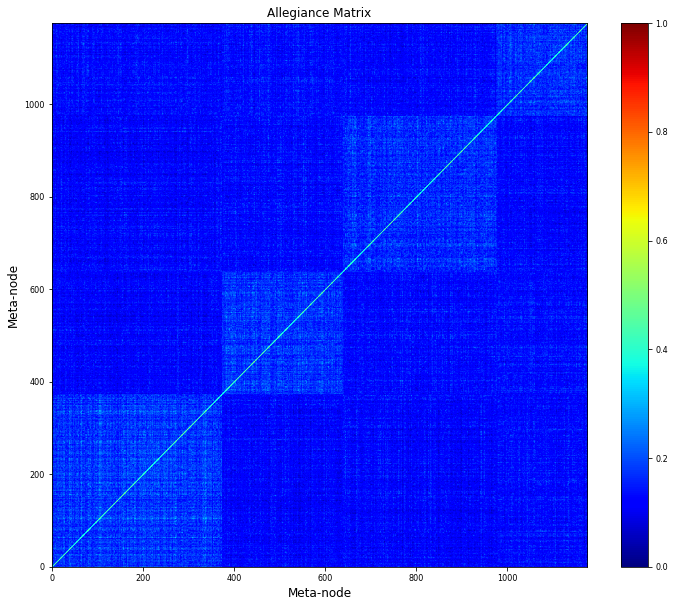

In [19]:
plt.figure(figsize=(12,10))
a,q = bc.modularity.modularity_finetune_und(T, seed=0)
ii  = np.argsort(a)
plt.imshow(T[np.ix_(ii,ii)], aspect="auto", cmap="jet", origin="lower")
plt.title("Allegiance Matrix", fontsize=BIGGER_SIZE)
plt.xlabel("Meta-node", fontsize=BIGGER_SIZE)
plt.ylabel("Meta-node", fontsize=BIGGER_SIZE)
plt.colorbar()

In [20]:
_FREQ = 1

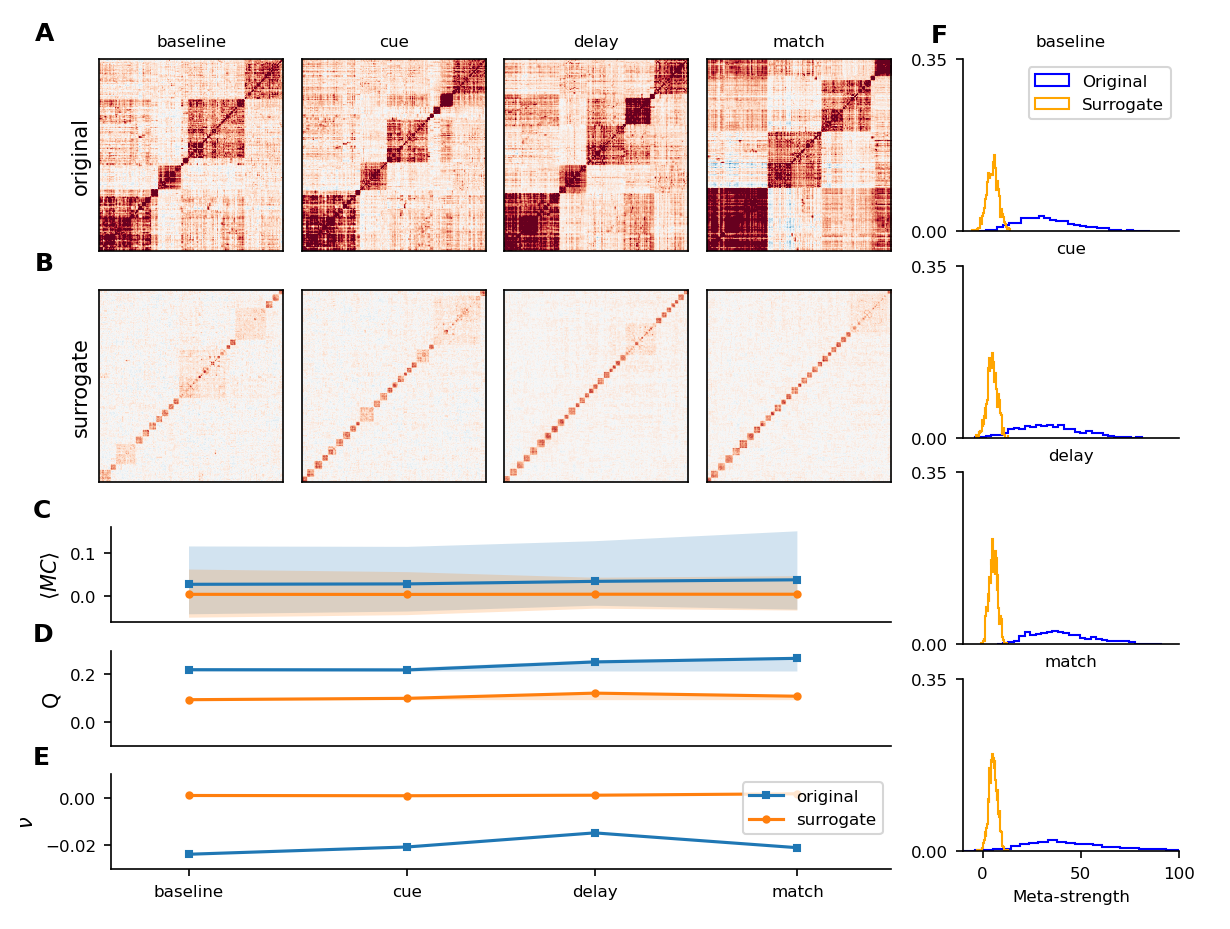

In [21]:
fig = plt.figure(figsize=(8, 6), dpi=150)

gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.07, right=0.73, bottom=0.48, top=0.95, wspace=.1)
gs2 = fig.add_gridspec(nrows=3, ncols=1, left=0.08, right=0.73, bottom=0.05, top=0.43, wspace=.1, hspace=.3)
gs3 = fig.add_gridspec(nrows=4, ncols=1, left=0.79, right=0.97, bottom=0.07, top=0.95, wspace=.1)


# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])
ax7 = plt.subplot(gs1[6])
ax8 = plt.subplot(gs1[7])

vmin=-0.1
vmax=0.1

ax_list = fig.get_axes()
or_axes = [0,1,2,3]
sr_axes = [4,5,6,7]

for i, ax_i in enumerate( or_axes ):
    plt.sca(ax_list[ax_i])
    ii = np.argsort(MC.attrs["aff_r"][:,_FREQ,i])
    plt.imshow(MC.isel(freqs=_FREQ,stages=i).values[np.ix_(ii,ii)],aspect="auto",cmap="RdBu_r", origin="lower",vmin=vmin,vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    plt.title(stages[i])
    if i==0: plt.ylabel("original")
    
for i, ax_i in enumerate( sr_axes ):
    plt.sca(ax_list[ax_i])
    ii = np.argsort(MC_surr.attrs["aff_r"][:,_FREQ,i])
    plt.imshow(MC_surr.isel(freqs=_FREQ,stages=i).values[np.ix_(ii,ii)],aspect="auto",cmap="RdBu_r", origin="lower",vmin=vmin,vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if i==0: plt.ylabel("surrogate")
    
    
# Panels C
ax10 = plt.subplot(gs2[0])
ax11 = plt.subplot(gs2[1])
ax12 = plt.subplot(gs2[2])

quantiles=[[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95]]

ax_list = fig.get_axes()

for i, ax_i in enumerate([8,9,10]):
    ax_list[ax_i].spines["top"].set_visible(False)
    ax_list[ax_i].spines["right"].set_visible(False)

_x = [0.1,0.38,0.62,0.88]    

#################################################################
# Mean meta-connectivity
#################################################################
plt.sca(ax10)
avg_MC = MC.isel(freqs=_FREQ).mean(axis=(0,1))
MCq05  = MC.isel(freqs=_FREQ).quantile(5/100, dim=("roi_1","roi_2"))
MCq95  = MC.isel(freqs=_FREQ).quantile(95/100, dim=("roi_1","roi_2"))
plt.plot(_x, avg_MC, 's-', ms=3)
plt.fill_between(_x, MCq05, MCq95, alpha=0.2)
avg_MC_surr = MC_surr.isel(freqs=_FREQ).mean(axis=(0,1))
MCq05_surr  = MC_surr.isel(freqs=_FREQ).quantile(5/100, dim=("roi_1","roi_2"))
MCq95_surr  = MC_surr.isel(freqs=_FREQ).quantile(95/100, dim=("roi_1","roi_2"))
plt.plot(_x, avg_MC_surr, 'o-', ms=3)
plt.fill_between(_x, MCq05_surr, MCq95_surr, alpha=0.2)
plt.ylabel(r"$\langle MC \rangle$")
#ax10.spines["bottom"].set_visible(False)
plt.xticks([])
plt.xlim([0,1])


#################################################################
# Modularity
#################################################################
plt.sca(ax11)
plt.plot(_x, MC.attrs["Q"][:,_FREQ,:].mean(axis=0), 's-', ms=3)
plt.fill_between(_x, np.quantile( MC.attrs["Q"][:,_FREQ,:], 5/100), 
                     np.quantile( MC.attrs["Q"][:,_FREQ,:], 95/100, axis=0), alpha=.2  )
plt.plot(_x, MC_surr.attrs["Q"][:,_FREQ,:].mean(axis=0), 'o-', ms=3)
plt.fill_between(_x, np.quantile( MC_surr.attrs["Q"][:,_FREQ,:], 5/100), 
                     np.quantile( MC_surr.attrs["Q"][:,_FREQ,:], 95/100, axis=0), alpha=.2  )
plt.ylabel("Q")
#ax11.spines["bottom"].set_visible(False)
plt.xticks([])
plt.xlim([0,1])
plt.ylim([-0.1,0.3])

#################################################################
# Viscosity
#################################################################
visc      = MC.where(MC<0).isel(freqs=_FREQ).mean(dim=("roi_1","roi_2"))
visc_surr = MC_surr.where(MC<0).isel(freqs=_FREQ).mean(dim=("roi_1","roi_2"))

plt.sca(ax12)
plt.plot(_x, visc, 's-', ms=3)
plt.plot(_x, visc_surr, 'o-', ms=3)
plt.ylabel(r"$\nu$")
#ax12.spines["bottom"].set_visible(False)
plt.xticks(_x, stages)
plt.xlim([0,1])
plt.ylim([-0.03,0.01])
plt.legend(["original","surrogate"], fontsize=SMALL_SIZE, loc='upper right')

# Panels B
ax13 = plt.subplot(gs3[0])
ax14 = plt.subplot(gs3[1])
ax15 = plt.subplot(gs3[2])
ax16 = plt.subplot(gs3[3])

ax_list = fig.get_axes()

for i, ax_i in enumerate([11,12,13,14]):
    plt.sca(ax_list[ax_i])
    plt.hist(MC.isel(freqs=_FREQ, stages=i).sum(axis=1), bins=30, density=True, 
             lw=1, histtype='step', fill=False, color="b",orientation="vertical")
    plt.hist(MC_surr.isel(freqs=_FREQ, stages=i).sum(axis=1), bins=50, density=True, 
             lw=1, histtype='step', fill=False, color="orange",orientation="vertical")
    if i==0: plt.legend(["Original", "Surrogate"], fontsize=SMALL_SIZE)
    if i<3:
        plt.xticks([])
    if i==3:
        plt.xlabel("Meta-strength", fontsize=SMALL_SIZE)
    plt.xlim([-10,100])
    plt.ylim([0,.35])
    plt.yticks([0,.35])
    ax_list[ax_i].spines["right"].set_visible(False)
    ax_list[ax_i].spines["top"].set_visible(False)
    plt.title(stages[i])
    
plot.add_panel_letters(fig, axes=[ax1, ax5, ax10, ax11, ax12, ax13], fontsize=12,
                           xpos=[-0.35,-0.35,-0.1,-0.1,-0.1,-0.15], ypos=[1.1, 1.1, 1.1, 1.1, 1.1, 1.1]);

bg = plot.Background(visible=False)

plt.savefig(f"img/n5.0.2/meta_conn_stats_f_{_FREQ}.png")

### MC spatial structure

In [22]:
#@nb.jit(nopython=True)
def compute_trimer_st(MC, x_s, x_t, av=None):
    
    # Get number of rois based on source/targets arrays
    n_rois  = np.concatenate((x_s,x_t)).astype(int).max()+1
    
    # If a affiliation vector is passed compute trimer-strengths
    # per module
    if av is not None:
        # Number of modules
        n_mods = av.max()
        ts     = np.zeros((n_mods,n_rois))
        for m in range(1,av.max()+1):
            # Get indexes of nodes inside module m
            i_m = (av==m)
            sources, targets = x_s[i_m], x_t[i_m]
            for i in range(n_rois):
                idx     = np.logical_or(sources==f"{i}", targets==f"{i}")
                ts[m-1,i] = MC[np.ix_(idx,idx)].sum()
    # Otherwise compute for each roi
    else:
        ts = np.zeros(n_rois)
        for i in range(n_rois):
            idx   = np.logical_or(x_s==f"{i}", x_t==f"{i}")
            ts[i] = MC[np.ix_(idx,idx)].sum()
    return ts

In [23]:
x_s, x_t = _extract_roi(MC.roi_1.values, "-")
A           = MC.isel(freqs=1,stages=2).values
#av, Q       = bc.modularity.modularity_finetune_und_sign(A, qtype="sta", seed=0)
Tst         = compute_trimer_st(A, x_s, x_t, MC.attrs["aff_r"][:,1,2].astype(int))

In [24]:
sorted_roi     = np.sort(net.super_tensor.attrs["areas"])
sorted_roi_idx = np.argsort(net.super_tensor.attrs["areas"]) 

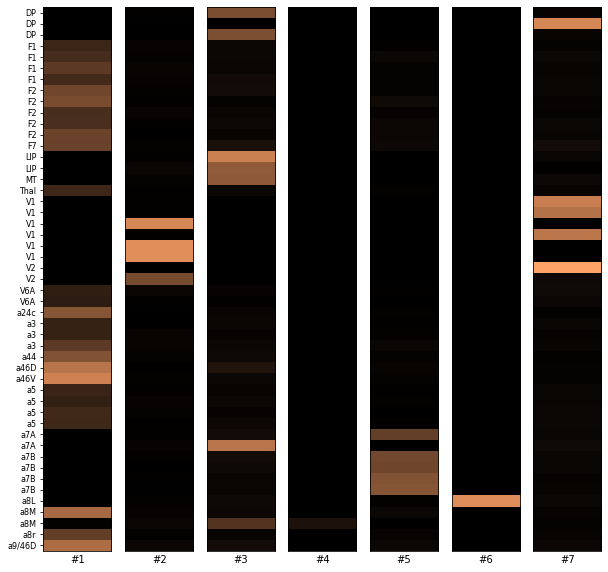

In [25]:
plt.figure(figsize=(10,10))
for i in range(Tst.shape[0]):
    plt.subplot(1,Tst.shape[0],i+1)
    plt.imshow(Tst[i,sorted_roi_idx][:,None], aspect="auto", cmap="copper", vmax=180, vmin=0)
    if i>0:  plt.yticks([])
    if i==0: plt.yticks(range(49), sorted_roi)
    plt.xlabel(f"#{i+1}")
    plt.xticks([])

##########################################################################